In [1]:
import sys
sys.path.append('../scripts/')
from dp_policy_agent import *

In [2]:
class StateInfo: ###stateinfo2
    def __init__(self, action_num):
        self.q = np.zeros(action_num)
        
    def greedy(self):
        return np.argmax(self.q)
    
    def pi(self):
        return self.greedy()

In [3]:
class QAgent(PuddleIgnoreAgent): ###qagent2（16行目以降）
    def __init__(self, time_interval, particle_pose, envmap, puddle_coef=100, \
                motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, widths=np.array([0.2, 0.2, math.pi/18]).T, \
                lowerleft=np.array([-4, -4]).T, upperright=np.array([4, 4]).T):   #goalを引数から消す

        super().__init__(time_interval, particle_pose, envmap, None, puddle_coef, motion_noise_stds) #goalにNoneを与える
        
        ###DynamicProgrammingから持ってくる###
        self.pose_min = np.r_[lowerleft, 0]
        self.pose_max = np.r_[upperright, math.pi*2]
        self.widths = widths
        self.index_nums = ((self.pose_max - self.pose_min)/self.widths).astype(int)
        nx, ny, nt = self.index_nums
        self.indexes = list(itertools.product(range(nx), range(ny), range(nt)))
        
        ###PuddleIgnorePolicyの方策と価値関数の読み込み###
        self.actions, self.ss = self.set_action_value_function()

    def set_action_value_function(self): #二つのファイルを読んで行動のリストと行動価値関数を初期化
        policy = np.zeros(np.r_[self.index_nums,2])
        for line in open("puddle_ignore_policy.txt", "r"): #方策のファイルを読み込む
            d = line.split()
            policy[int(d[0]), int(d[1]), int(d[2])] = [float(d[3]), float(d[4])]
        
        actions = list(set([tuple(policy[i]) for i in self.indexes])) #行動のリスト（前進、左回転、右回転のリストに）
        action_num = len(actions) #行動のリストの要素数
        
        ss = {} #state spaceという意味
        for line in open("puddle_ignore_values.txt", "r"): #価値のファイルを読み込む
            d = line.split()
            index, value = (int(d[0]), int(d[1]), int(d[2])), float(d[3]) #インデックスをタプル、値を数字に
            ss[index] = StateInfo(action_num) #StateInfoオブジェクトを割り当てて初期化
            
            for i, a in enumerate(actions): #方策の行動価値を価値のファイルに書いてある値に。そうでない場合はちょっと引く
                ss[index].q[i] = value if tuple(policy[index]) == a else value - 0.1
                
        return actions, ss
    
    def policy(self, pose): #dp_policy_agentからコピーして後半を変更
        index = np.floor((pose - self.pose_min)/self.widths).astype(int)
        
        index[2] = (index[2] + self.index_nums[2]*1000)%self.index_nums[2]
        for i in [0,1]:
            if index[i] < 0: index[i] = 0
            elif index[i] >= self.index_nums[i]: index[i] = self.index_nums[i] - 1
                
        a = self.ss[tuple(index)].pi() #行動価値関数を使うように書き換え
        return self.actions[a]
        
    def decision(self, observation=None): #PuddleIgnoreAgentからコピー
        if self.in_goal:
            return 0.0, 0.0
        
        self.kf.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.kf.observation_update(observation)
        
        self.total_reward += self.time_interval*self.reward_per_sec()
        
        nu, omega = self.policy(self.kf.belief.mean) #self.goalを削る
        self.prev_nu, self.prev_omega = nu, omega
        return nu, omega

<IPython.core.display.Javascript object>


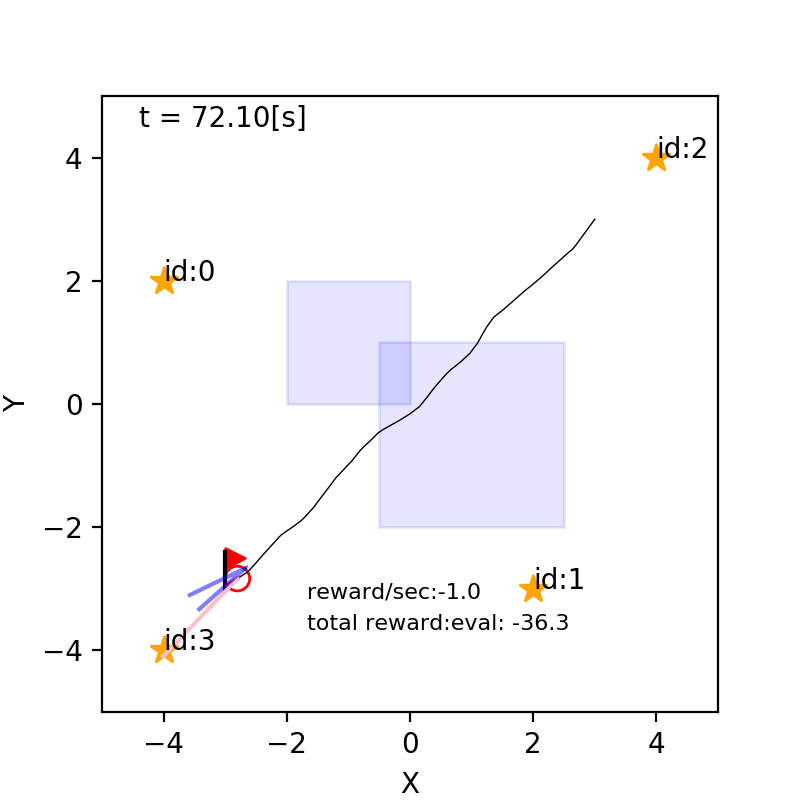

In [4]:
if __name__ == '__main__': 
    time_interval = 0.1
    world = PuddleWorld(400000, time_interval)  #長時間アニメーション時間をとる

    m = Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(4,4))
    m.append_landmark(Landmark(-4,-4))
    world.append(m)
    
    ###ゴールの追加###
    goal = Goal(-3,-3)
    world.append(goal)
    
    ###水たまりの追加###
    world.append(Puddle((-2, 0), (0, 2), 0.1)) 
    world.append(Puddle((-0.5, -2), (2.5, 1), 0.1))

    ###ロボットを1台登場させる###
    init_pose = np.array([3, 3, 0]).T
    qa = QAgent(time_interval, init_pose, m)  #地図を消す
    r = Robot(init_pose, sensor=Camera(m, distance_bias_rate_stddev=0, direction_bias_stddev=0), 
              agent=qa, color="red", bias_rate_stds=(0,0))

    world.append(r)
    
    world.draw()
    #r.one_step(0.1) #デバッグ時